In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Optimal Parameters:
a=0.1005, b=0.0607, sigma=0.0280, r0=0.0340


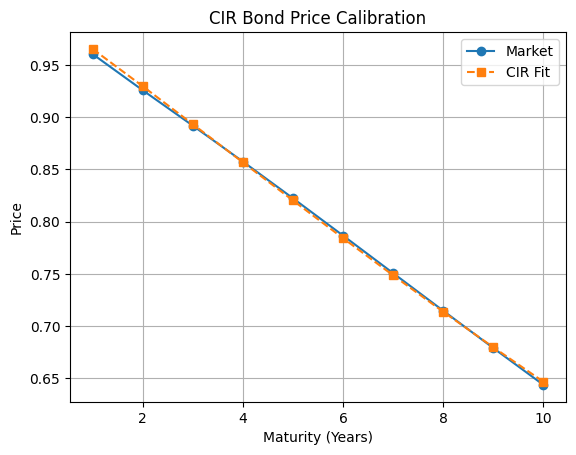

RMSE: 0.002577


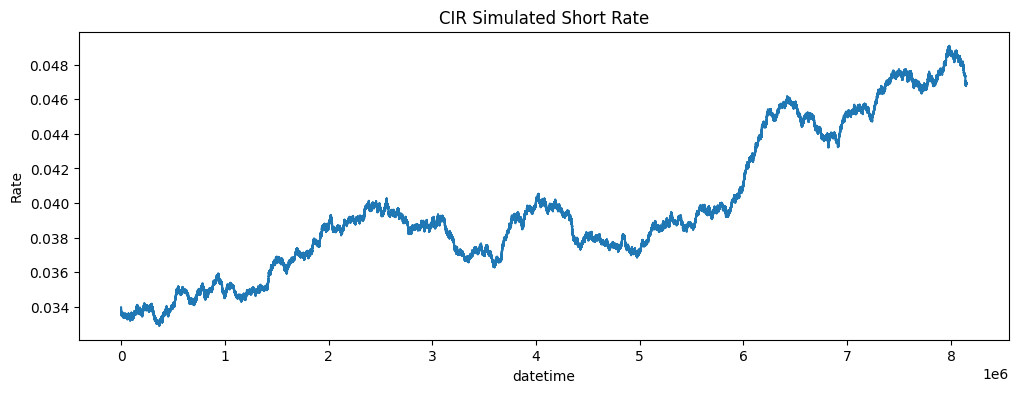

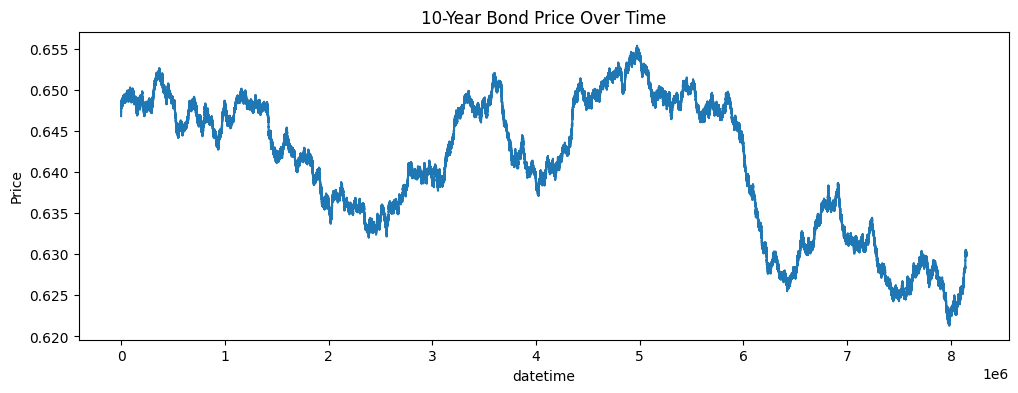

In [26]:
%run Simulated_bond_data.ipynb

In [27]:
price_book = pd.read_csv("Data/simulated_bond_data.csv")
price_book['spread'] = price_book['ask_price'] - price_book['bid_price']

In [28]:
len(price_book)

8149680

In [29]:
def estimate_k_and_A(window_df):
    window_df = window_df.copy()
    window_df['spread_bin'] = pd.cut(window_df['spread'], bins=np.arange(0, 0.1, 0.0025))
    volume_by_bin = window_df.groupby('spread_bin', observed=True)['volume'].sum().reset_index()
    volume_by_bin = volume_by_bin[volume_by_bin['volume'] > 0]
    volume_by_bin['bin_mid'] = volume_by_bin['spread_bin'].apply(lambda x: x.mid)

    X = volume_by_bin['bin_mid'].values
    y = np.log(volume_by_bin['volume'].values)

    if len(X) < 2:
        return None, None

    slope, intercept = np.polyfit(X, y, deg=1)
    k = -slope
    A = np.exp(intercept)
    return k, A / 1200 


In [30]:
def estimate_liquidity_curves(window):
    """
    Estimate A and k separately for bid and ask sides over a given window.

    Returns:
        k_bid, A_bid, k_ask, A_ask
    """
    # Bid-side
    bid_window = window[['mid_price', 'bid_price', 'vol_bid']].copy()
    bid_window['spread'] = bid_window['mid_price'] - bid_window['bid_price']
    bid_window = bid_window.rename(columns={'vol_bid': 'volume'})
    k_bid, A_bid = estimate_k_and_A(bid_window)

    # Ask-side
    ask_window = window[['ask_price', 'mid_price', 'vol_ask']].copy()
    ask_window['spread'] = ask_window['ask_price'] - ask_window['mid_price']
    ask_window = ask_window.rename(columns={'vol_ask': 'volume'})
    k_ask, A_ask = estimate_k_and_A(ask_window)

    return k_bid, A_bid, k_ask, A_ask


In [31]:
base_spread = .04
gamma = 0.1

In [32]:
inventory = 0
cash = 0
book = []
trades = []
volume = []

for index in tqdm(range(1201, len(price_book))):
    # Group spread and volume count to estimate liquidity
    if index % 1201 == 0:
        window = price_book.loc[index - 1200 : index - 1]
        k_bid, A_bid, k_ask, A_ask = estimate_liquidity_curves(window)

    # Set bid/ask
    mid = price_book.loc[index - 1, 'mid_price']
    bid = mid - base_spread / 2 - gamma * inventory
    bid = min(mid, bid - .01)

    ask = mid + base_spread / 2 - gamma * inventory
    ask = max(mid, ask + .01)
    # Calculate number of trades
    
    dist_to_bid = abs(mid - bid)
    dist_to_ask = abs(ask - mid)

    lambda_t_bid = A_bid * np.exp(-k_bid * dist_to_bid) if A_bid is not None else 0
    lambda_t_ask = A_ask * np.exp(-k_ask * dist_to_ask) if A_ask is not None else 0

    num_trades_bid = np.random.poisson(lam=lambda_t_bid)
    num_trades_ask = np.random.poisson(lam=lambda_t_ask)

    for _ in range(num_trades_bid):
        inventory += 1
        cash -= bid

    for _ in range(num_trades_ask):
        inventory -= 1
        cash += ask

    volume.append(num_trades_bid + num_trades_ask)
    trades.append(inventory)
    book.append(cash)

100%|██████████| 8148479/8148479 [02:00<00:00, 67775.78it/s]


In [34]:

cash_df = pd.DataFrame({
    'cash': book,
    'inventory': trades,
    'volume': volume
})


# Simulate timestamps assuming 1-second intervals
cash_df['timestamp'] = pd.date_range(start='2025-07-03 08:00:00', periods=len(book), freq='s')
cash_df.set_index('timestamp', inplace=True)

# Resample over 5-minute intervals (300 seconds)
cash_5min = cash_df['cash'].resample('539min').mean()
book_5min = cash_df['inventory'].resample('539min').mean()
volume_5min = cash_df['volume'].resample('539min').sum()
returns_10m = np.log(cash_5min / cash_5min.shift(1))


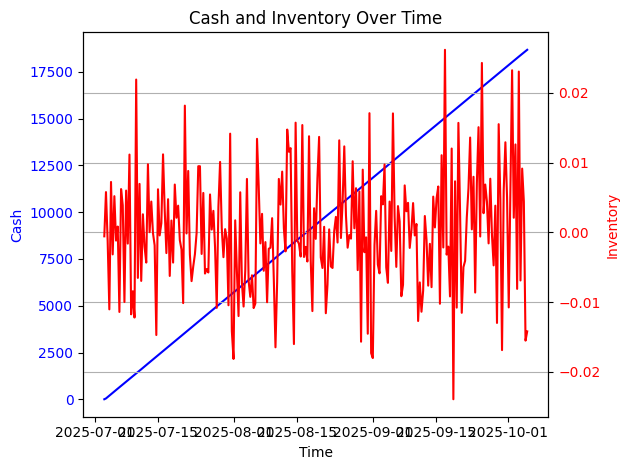

In [35]:

fig, ax1 = plt.subplots()
ax1.set_xlabel('Time')
ax1.set_ylabel('Cash', color='blue')
ax1.plot(cash_5min, color='blue', label='Cash')
ax1.tick_params(axis='y', labelcolor='blue')

# Second y-axis (shared x-axis)
ax2 = ax1.twinx()
ax2.set_ylabel('Inventory', color='red')
ax2.plot(book_5min, color='red', label='Inventory')
ax2.tick_params(axis='y', labelcolor='red')

# Title and layout
plt.title('Cash and Inventory Over Time')
fig.tight_layout()
plt.grid(True)
plt.show()

Locator attempting to generate 2491 ticks ([20267.291666666668, ..., 20371.041666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2491 ticks ([20267.291666666668, ..., 20371.041666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2491 ticks ([20267.291666666668, ..., 20371.041666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2491 ticks ([20267.291666666668, ..., 20371.041666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2491 ticks ([20267.291666666668, ..., 20371.041666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2491 ticks ([20267.291666666668, ..., 20371.041666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2491 ticks ([20267.291666666668, ..., 20371.041666666668]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 2491 ticks ([20267.291666666668, ..., 20371.041666666668]),

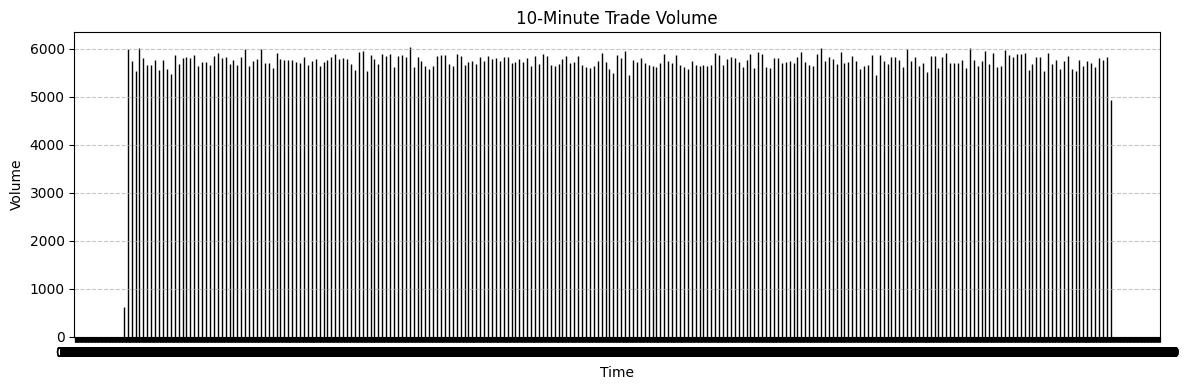

In [36]:
plt.figure(figsize=(12, 4))
plt.bar(volume_5min.index, volume_5min.values, width=0.003, color='tab:gray', edgecolor='black')

# Format x-axis to show only time (HH:MM) every hour
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator())

plt.title('10-Minute Trade Volume')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

<Axes: title={'center': 'Log Returns After 11:00 AM'}, xlabel='timestamp'>

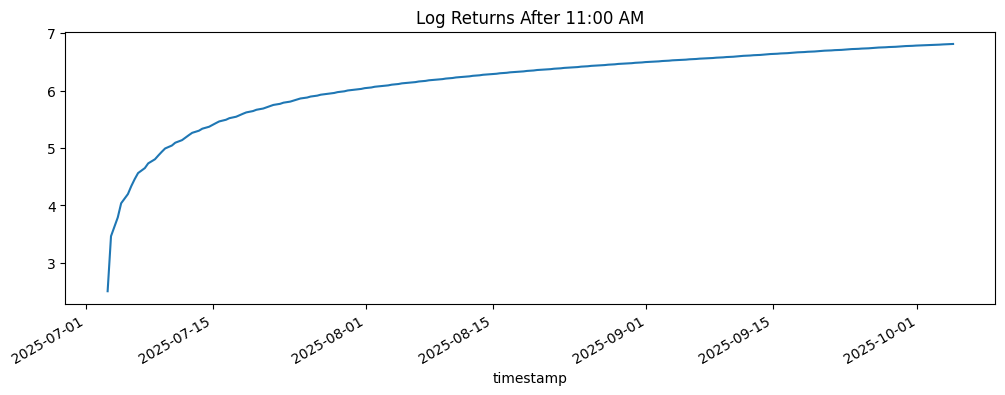

In [37]:
zoomed_returns = returns_10m[returns_10m.index.time >= pd.to_datetime("8:00").time()]
zoomed_returns.cumsum().fillna(0).plot(figsize=(12, 4), title="Log Returns After 11:00 AM")

# plt.xlabel('Time')
# print(cumsum.tail(10))

<Axes: title={'center': '10-Minute Log Returns'}, xlabel='timestamp'>

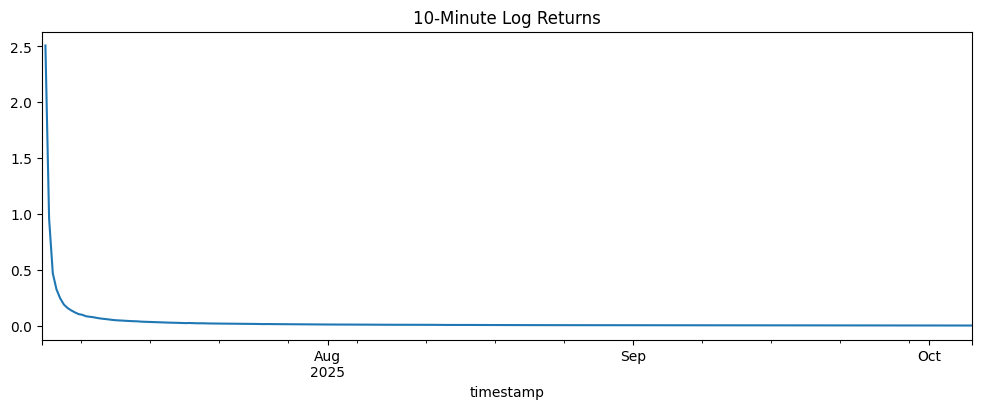

In [38]:
returns_10m.plot(figsize=(12, 4), title="10-Minute Log Returns")

<Axes: title={'center': 'Cumulative Cash Returns'}, xlabel='timestamp'>

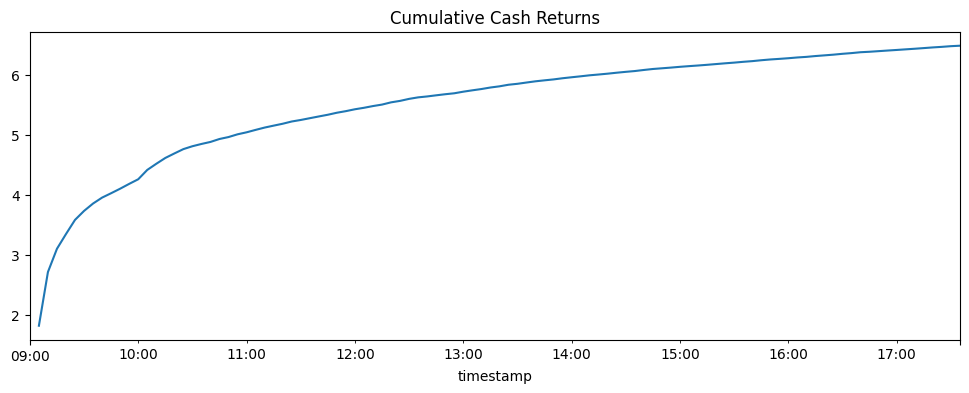

In [17]:
cash_returns = cash_5min.diff() / cash_5min.shift(1)
cash_returns.cumsum().plot(figsize=(12, 4), title="Cumulative Cash Returns")

<Axes: title={'center': 'Total Cash Over Time'}, xlabel='timestamp'>

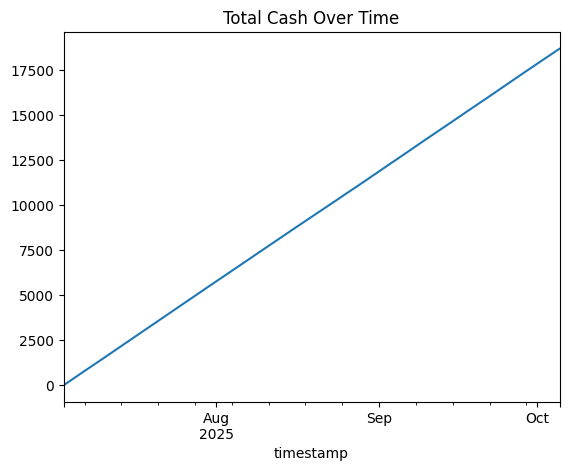

In [39]:
cash_5min.plot(title="Total Cash Over Time")